# Can you accurately predict the prices of houses in Nigeria?

### NB This work is an improved work of a publicly avaliable notebook on Kaggle, https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf

### The tfdf model from the Kaggle notebook is used here. The preprocessing and exploration methods are diffferent.

This notebook walks you through how to predict the price of a house, detailing the data exploration, feature engineering and model building methods. Unlike regular machine learning workflows, we'll be using Tensorflow to prepare, train, and make predictions.

train a baseline Random Forest model and Gradient Boost Trees using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

### Objective

The objective of the challenge is to predict the price (Amount (Million Naira) the company should sell a car based on the available data (ID, Location, , Amount (Million Naira), Bathroom, Bedroom, Parking space. The objective is to predict the price.

- Train.csv: Training data
- Test.csv: Test data
- Sample Submission.csv: Submission file

To acheive this objective, we'll follow the following steps
- Importing the data
- Exploring the data
- Feature Engineering and transformation
- Modelling
- Final prediction
- Submission

## Import the library

In [ ]:
%pip install -q tensorflow_decision_forests

In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [ ]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.13.0
TensorFlow Decision Forests v1.5.0


## Load the Training dataset


In [ ]:
# Mounting Google drive to load the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_file_path = "/content/drive/MyDrive/dsn2023/Housing_dataset_train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (14000, 7)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [ ]:
dataset_df.head(3)

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814


* There are 6 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `price`.

In [ ]:
len(dataset_df.ID.unique())

10182

We will drop the `Id` column as it is not necessary for model training.

In [ ]:
dataset_df = dataset_df.drop('ID', axis=1)
dataset_df.head(3)

,loc,title,bedroom,bathroom,parking_space,price
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,Ekiti,NaN,7.0,5.0,NaN,3364799.814


We can inspect the types of feature columns using the following code:

In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            12187 non-null  object 
 1   title          12278 non-null  object 
 2   bedroom        12201 non-null  float64
 3   bathroom       12195 non-null  float64
 4   parking_space  12189 non-null  float64
 5   price          14000 non-null  float64
dtypes: float64(4), object(2)
memory usage: 656.4+ KB


In [ ]:
# Quick aggregation
dataset_df.describe()

,bedroom,bathroom,parking_space,price
count,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4.308171,3.134235,3.169825,2.138082e+06
std,2.441165,2.035950,1.599415,1.083057e+06
min,1.000000,1.000000,1.000000,4.319673e+05
25%,2.000000,1.000000,2.000000,1.393990e+06
50%,4.000000,2.000000,3.000000,1.895223e+06
75%,6.000000,5.000000,4.000000,2.586699e+06
max,9.000000,7.000000,6.000000,1.656849e+07


Some houses have large number of bedrooms and bathrooms, which sugest that they are either for large families, rental houses, or extremely rich people.

In [ ]:
dataset_df.isnull().sum()

loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [ ]:
print('Unique Housetype', dataset_df.title.unique())
print('Unique Location', dataset_df['loc'].unique())
print('Unique bedroom', dataset_df.title.unique())
print('Unique parking_space', dataset_df['loc'].unique())
print('Unique bathroom', dataset_df.title.unique())

Unique Housetype ['Semi-detached duplex' 'Apartment' nan 'Detached duplex' 'Terrace duplex'
 'Mansion' 'Bungalow' 'Penthouse' 'Townhouse' 'Flat' 'Cottage']
Unique Location ['Katsina' 'Ondo' 'Ekiti' 'Anambra' 'Kogi' 'Borno' 'Kwara' 'Osun' 'Kaduna'
 'Ogun' 'Bayelsa' nan 'Abia' 'Rivers' 'Taraba' 'Ebonyi' 'Kebbi' 'Enugu'
 'Edo' 'Nasarawa' 'Delta' 'Kano' 'Yobe' 'Benue' 'Bauchi' 'Cross River'
 'Niger' 'Adamawa' 'Plateau' 'Imo' 'Oyo' 'Zamfara' 'Sokoto' 'Jigawa'
 'Gombe' 'Akwa Ibom' 'Lagos']
Unique bedroom ['Semi-detached duplex' 'Apartment' nan 'Detached duplex' 'Terrace duplex'
 'Mansion' 'Bungalow' 'Penthouse' 'Townhouse' 'Flat' 'Cottage']
Unique parking_space ['Katsina' 'Ondo' 'Ekiti' 'Anambra' 'Kogi' 'Borno' 'Kwara' 'Osun' 'Kaduna'
 'Ogun' 'Bayelsa' nan 'Abia' 'Rivers' 'Taraba' 'Ebonyi' 'Kebbi' 'Enugu'
 'Edo' 'Nasarawa' 'Delta' 'Kano' 'Yobe' 'Benue' 'Bauchi' 'Cross River'
 'Niger' 'Adamawa' 'Plateau' 'Imo' 'Oyo' 'Zamfara' 'Sokoto' 'Jigawa'
 'Gombe' 'Akwa Ibom' 'Lagos']
Unique bathroom ['S

Investigating the number of bathrooms and bedrooms. The more common houses are those that have between 1 to 5 bedrooms and 1 to 3 bathrooms.

In [ ]:
pd.crosstab(dataset_df.bedroom, dataset_df.bathroom)

bathroom,1.0,2.0,3.0,4.0,5.0,6.0,7.0
bedroom,,,,,,,
1.0,491,443,112,95,113,115,114
2.0,478,471,125,102,109,101,113
3.0,455,471,117,103,120,110,115
4.0,474,440,92,97,105,111,112
5.0,475,532,93,117,108,106,114
6.0,128,119,91,114,111,99,107
7.0,111,87,111,132,104,103,108
8.0,102,102,109,106,104,100,112
9.0,105,122,95,90,103,128,117


In [ ]:
# Correlation between bathroom and parking_space
dataset_df.bathroom.corr(dataset_df.parking_space)

0.17849681632286413

<Axes: >

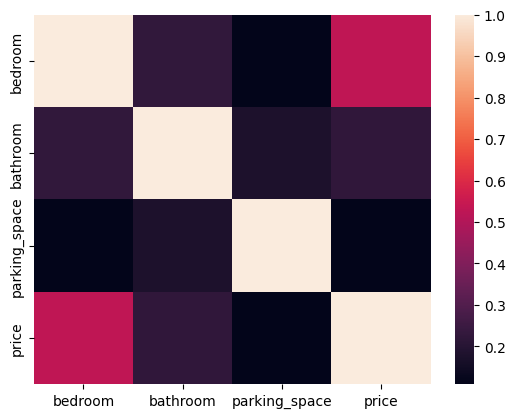

In [ ]:
# Correlation between the features
import seaborn as sns

a = dataset_df[['bedroom', 'bathroom', 'parking_space', 'price']].corr()
sns.heatmap(a)

We can see that bedroom has a higher correlation to price than others. It shows that the higher the number of bedrooms, the higher the price.

There's also a significant correlation between bedrooms and bathrooms. The more the bedrooms, the more the bathrooms, which is quite logical

In [ ]:
pd.pivot_table(data=dataset_df, values='parking_space', columns=['bedroom'], index='bathroom', aggfunc=np.sum)

bedroom,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
bathroom,,,,,,,,,
1.0,1207.0,1107.0,1012.0,1099.0,1035.0,385.0,304.0,310.0,358.0
2.0,989.0,1099.0,1063.0,985.0,1161.0,310.0,257.0,346.0,330.0
3.0,317.0,409.0,398.0,251.0,286.0,283.0,325.0,329.0,270.0
4.0,282.0,297.0,294.0,296.0,339.0,342.0,454.0,286.0,234.0
5.0,340.0,291.0,390.0,314.0,336.0,344.0,320.0,314.0,288.0
6.0,315.0,308.0,332.0,315.0,312.0,306.0,325.0,285.0,378.0
7.0,357.0,301.0,300.0,335.0,364.0,339.0,366.0,317.0,342.0


<Axes: xlabel='loc'>

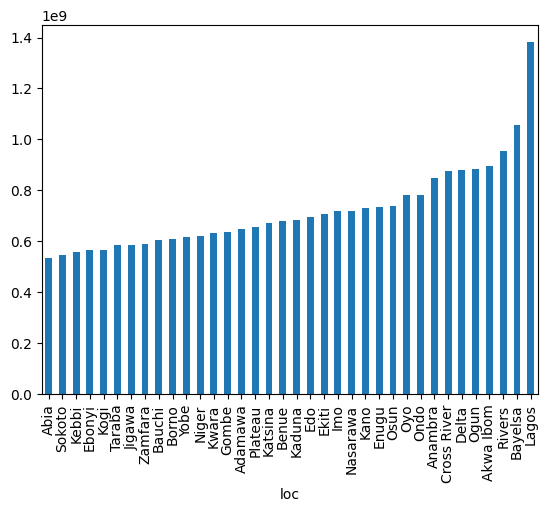

In [ ]:
# Price difference across states in Nigeria
a = dataset_df.groupby('loc')['price'].sum().sort_values()
a.plot.bar()

It's evident that some states will have higher priced houses for the same house type.

<Axes: >

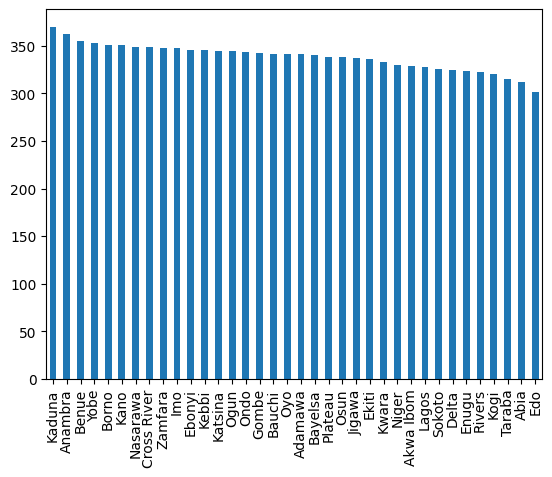

In [ ]:
dataset_df['loc'].value_counts().plot.bar()

We have more houses in the Northern parts than the South, but houses are more expensive in the South than in the North

## Feature Engineering

In [ ]:

# Creating 2 new features based on the bedroom, bathroom, and parking space
dataset_df['bedroom_per_bathroom'] = round(dataset_df.bedroom+1/dataset_df.bathroom, 0)
dataset_df['parking_space_per_bedroom'] = round(dataset_df.parking_space+1/dataset_df.bedroom, 0)

# Transforming the location feature to Geo Political Zones
map = {
    'Benue':'North-Central', 'Kogi':'North-Central', 'Kwara':'North-Central', 'Nasarawa':'North-Central', 'Niger':'North-Central', 'Plateau':'North-Central', 'Abuja':'North-Central',
    'Adamawa':'North-East', 'Bauchi':'North-East', 'Borno':'North-East', 'Gombe':'North-East', 'Taraba':'North-East', 'Yobe':'North-East',
    'Jigawa':'North-West', 'Kaduna':'North-West', 'Kano':'North-West', 'Katsina':'North-West', 'Kebbi':'North-West', 'Sokoto':'North-West', 'Zamfara':'North-West',
    'Abia':'South-East', 'Anambra':'South-East', 'Ebonyi':'South-East', 'Enugu':'South-East', 'Imo':'South-East',
    'Akwa Ibom':'South-South', 'Bayelsa':'South-South', 'Cross River':'South-South', 'Delta':'South-South', 'Edo':'South-South', 'Rivers':'South-South',
    'Ekiti':'South-West', 'Lagos':'South-West', 'Ogun':'South-West', 'Ondo':'South-West', 'Osun':'South-West', 'Oyo':'South-West'
}
dataset_df['GeoPoliticalZone'] = dataset_df['loc'].copy()
dataset_df['GeoPoliticalZone'] = dataset_df['GeoPoliticalZone'].map(map)

# Creating a new feature for houses and apartments
dataset_df['house_vs_room'] = dataset_df.title.copy()

map = {'Semi-detached duplex':'house', 'Apartment':'room',
        'Detached duplex':'house', 'Terrace duplex':'house',
        'Mansion':'house', 'Bungalow':'house', 'Penthouse':'house',
        'Townhouse':'house', 'Flat':'room', 'Cottage':'house'}

dataset_df['house_vs_room'] = dataset_df['house_vs_room'].map(map)

# Ranking the house_vs_room feature to convert it to numerical data
map = {'house':1, 'room':2}
dataset_df['house_vs_room'] = dataset_df['house_vs_room'].map(map)

# Ranking the house type feature to convert it to numerical data
house_type_ranks = {
    'Cottage': 1,
    'Bungalow': 2,
    'Townhouse': 3,
    'Terrace duplex': 4,
    'Detached duplex': 5,
    'Semi-detached duplex': 6,
    'Flat': 7,
    'Penthouse': 8,
    'Apartment': 9,
    'Mansion': 10
}

dataset_df['title'] = dataset_df['title'].map(house_type_ranks)

# Map the zones to numerical values based on size ranking
house_type_ranks = {
    'North-West': 3,
    'South-West': 2,
    'South-East': 6,
    'North-Central': 4,
    'North-East': 5,
    'South-South': 1
}


dataset_df['GeoPoliticalZone'] = dataset_df['GeoPoliticalZone'].map(house_type_ranks)



## House Price Distribution

Now let us take a look at how the house prices are distributed.

count    1.400000e+04
mean     2.138082e+06
std      1.083057e+06
min      4.319673e+05
25%      1.393990e+06
50%      1.895223e+06
75%      2.586699e+06
max      1.656849e+07
Name: price, dtype: float64


<ipython-input-21-36dd23dbf939>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['price'], color='g', bins=100, hist_kws={'alpha': 0.4});


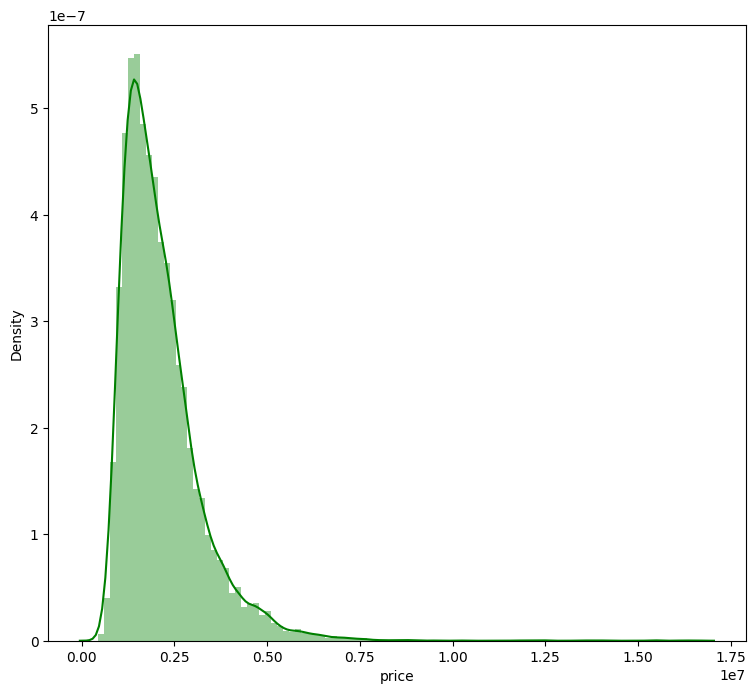

In [ ]:
print(dataset_df['price'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['price'], color='g', bins=100, hist_kws={'alpha': 0.4});

<ipython-input-22-246f3d80106f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.johnsonsu)
<ipython-input-22-246f3d80106f>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.norm)
<ipython-input-22-246f3d80106f>:8: UserWarning: 

`distplot` is a dep

<Axes: title={'center': 'Log Normal'}, xlabel='price'>

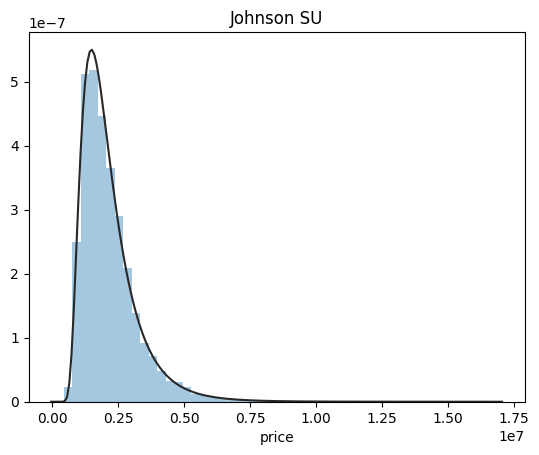

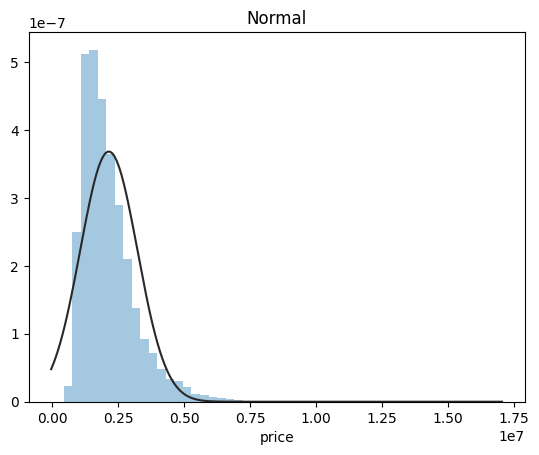

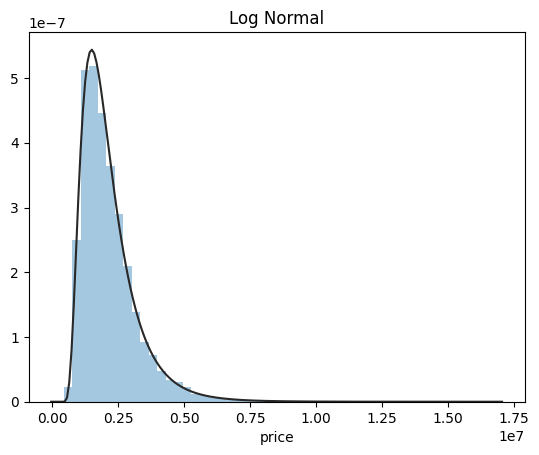

In [ ]:
# Explloring other types of tranformation methods for the target - house price
y = dataset_df['price']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

<ipython-input-23-977835a68b17>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.sqrt(dataset_df['price']), color='g', bins=100, hist_kws={'alpha': 0.4});


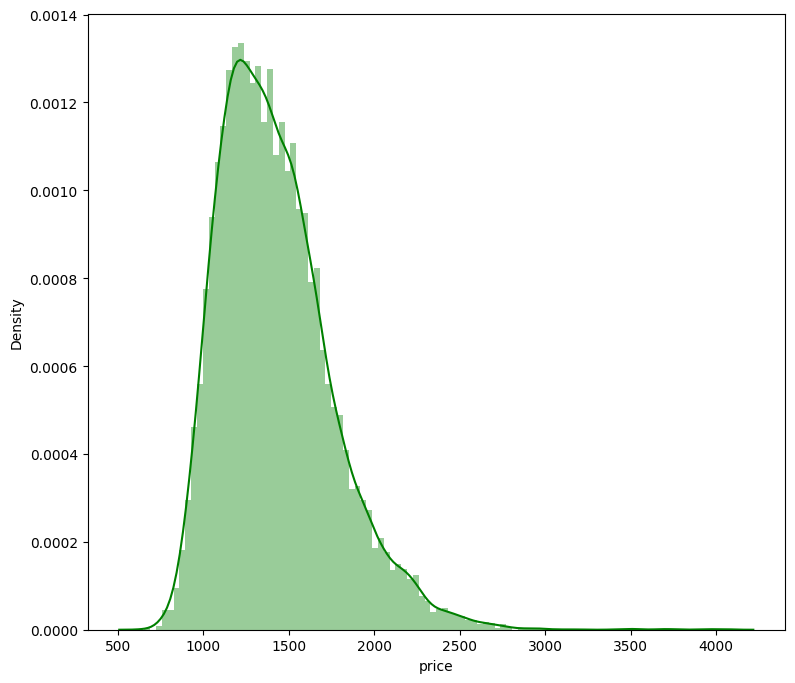

In [ ]:
plt.figure(figsize=(9, 8))
# Using the square root transformation
sns.distplot(np.sqrt(dataset_df['price']), color='g', bins=100, hist_kws={'alpha': 0.4});

In [ ]:
import numpy as np

dataset_df['price'] = np.sqrt(dataset_df.price)

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [ ]:
list(set(dataset_df.dtypes.tolist()))

[dtype('float64'), dtype('O')]

In [ ]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,title,bedroom,bathroom,parking_space,price,bedroom_per_bathroom,parking_space_per_bedroom,GeoPoliticalZone,house_vs_room
0,6.0,2.0,2.0,1.0,1072.380327,2.0,2.0,3.0,1.0
1,9.0,NaN,2.0,4.0,1293.219505,NaN,NaN,2.0,2.0
2,NaN,7.0,5.0,NaN,1834.339067,7.0,NaN,2.0,NaN
3,5.0,5.0,2.0,4.0,1552.516266,6.0,4.0,6.0,1.0
4,4.0,NaN,5.0,6.0,1612.668874,NaN,NaN,4.0,1.0


Now let us plot the distribution for all the numerical features.

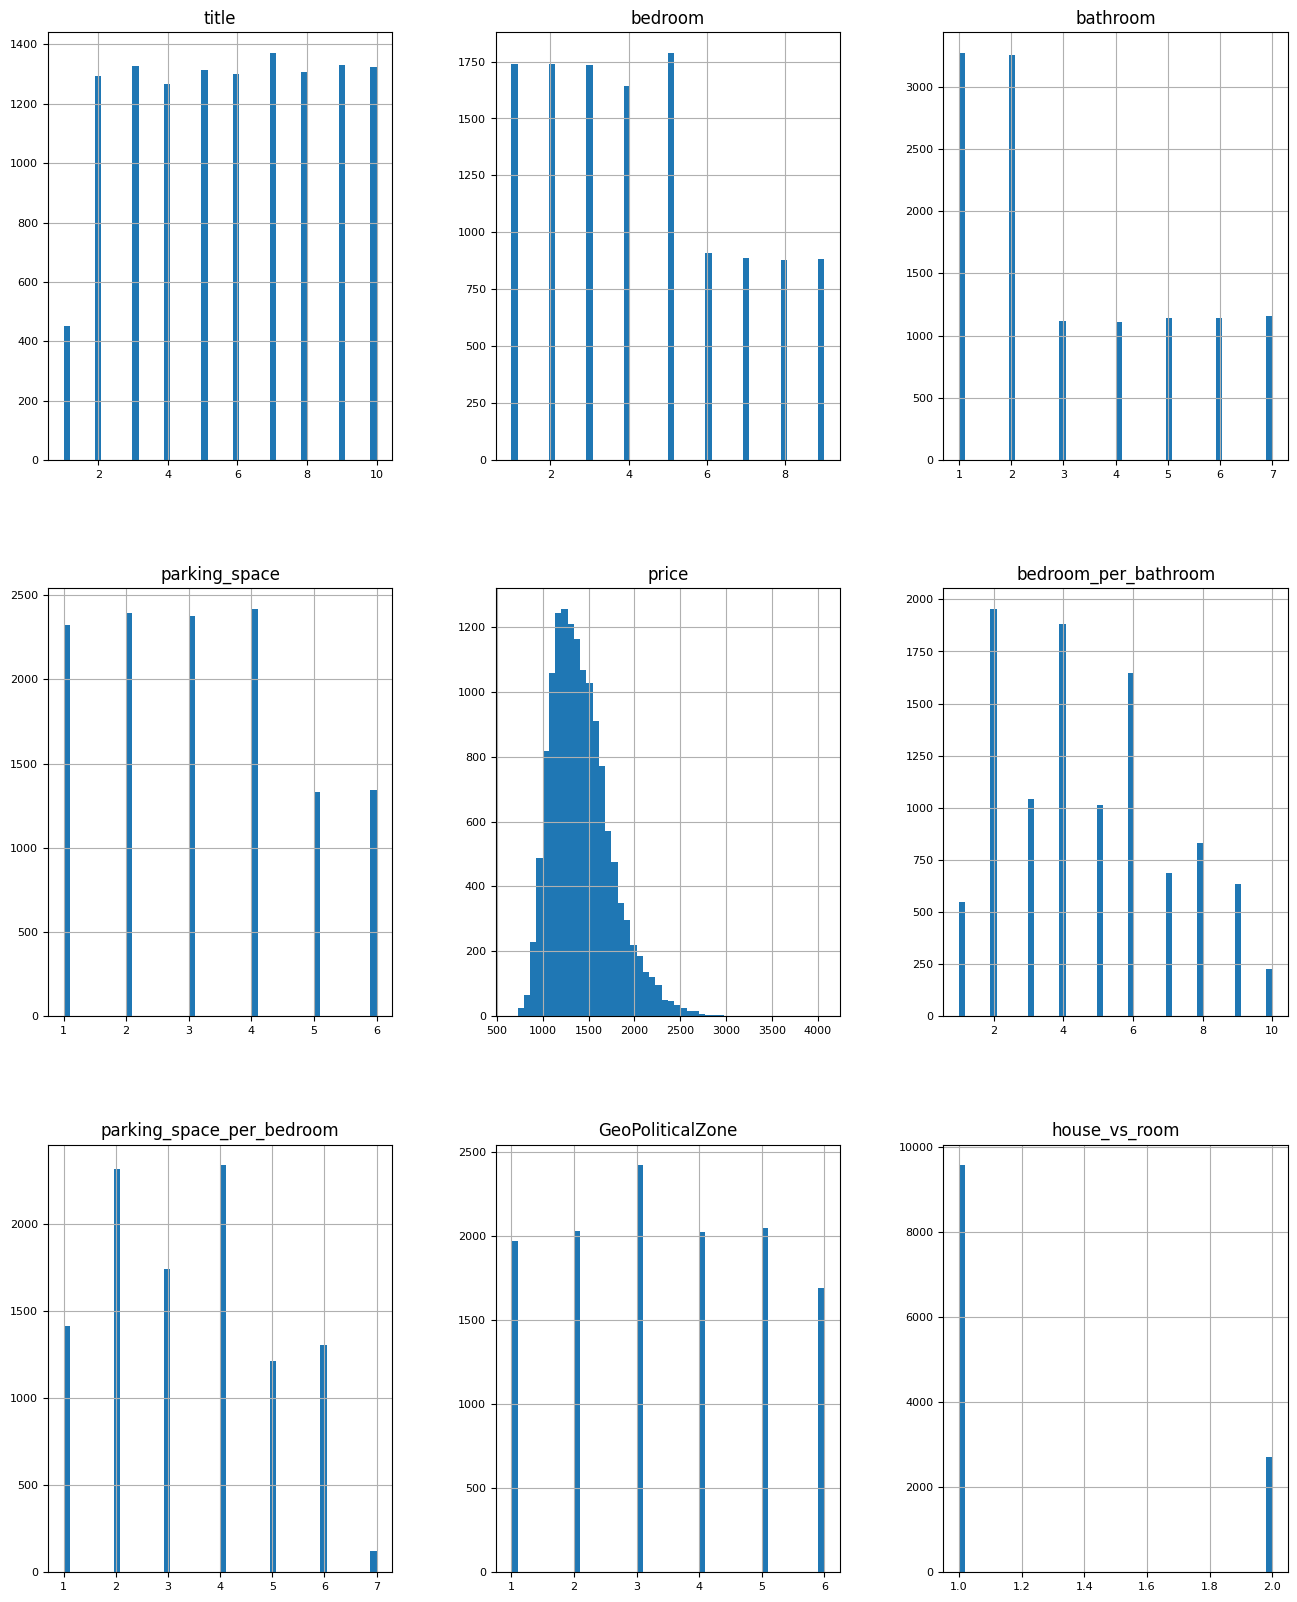

In [ ]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Majority of the numerical data are categories, so there won't be extra transformations.

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

In [ ]:
import numpy as np

def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

11154 examples in training, 2846 examples in testing.


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [ ]:
label = 'price'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

## Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [ ]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

## Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

In [ ]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpiiszi6l8 as temporary training directory


## Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [ ]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:15.890053. Found 11154 examples.
Training model...
Model trained in 0:00:16.720296
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


## Visualize the model
One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [ ]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

## Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

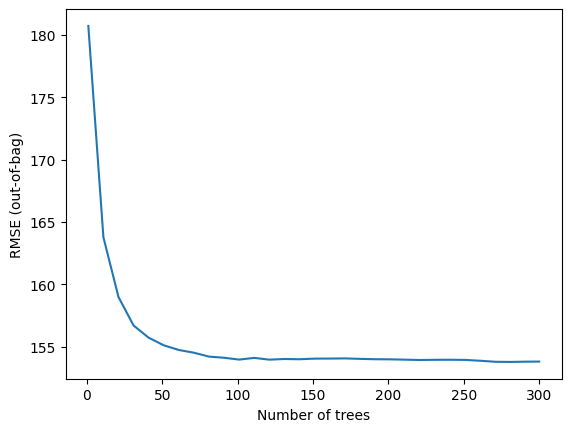

In [ ]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

We can also see some general stats on the OOB dataset:

In [ ]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=11154, accuracy=None, loss=None, rmse=153.80867620697995, ndcg=None, aucs=None, auuc=None, qini=None)

Now, let us run an evaluation using the validation dataset.

In [ ]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

3/3 [==============================] - 1s 139ms/step - loss: 0.0000e+00 - mse: 25682.4531
loss: 0.0000
mse: 25682.4531


## Variable importance

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [ ]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 NUM_NODES
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [ ]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("bedroom" (1; #3), 135.0),
 ("title" (1; #9), 90.0),
 ("bedroom_per_bathroom" (1; #4), 39.0),
 ("loc" (4; #6), 23.0),
 ("GeoPoliticalZone" (1; #0), 10.0),
 ("house_vs_room" (1; #5), 3.0)]

Plot the variable importances from the inspector using Matplotlib

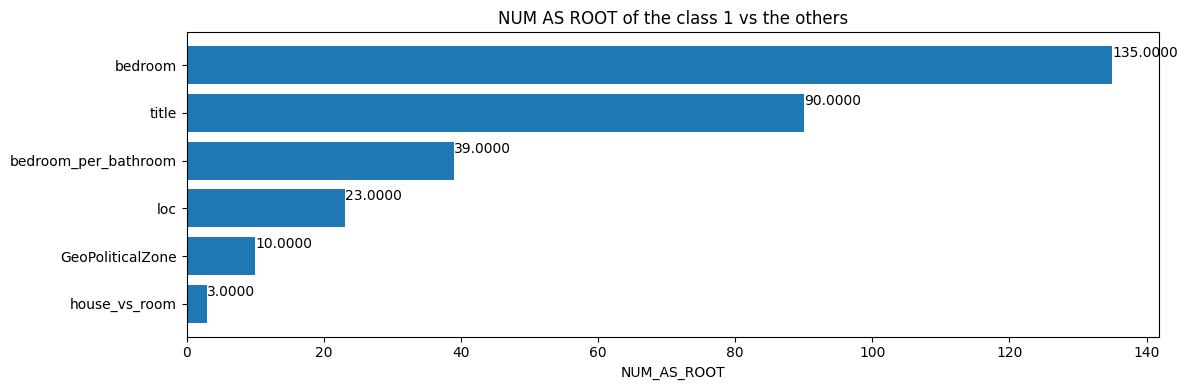

In [ ]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

## Model 2 - Create a Gradient Boosted Tree Model

In [ ]:
gbf = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)
gbf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpr7dzjvbp as temporary training directory


## Train the Model

In [ ]:
gbf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.351812. Found 11154 examples.
Training model...
Model trained in 0:00:02.130736
Compiling model...
Model compiled.


## Visualize the model

In [ ]:
tfdf.model_plotter.plot_model_in_colab(gbf, tree_idx=0, max_depth=3)

## Evaluate the model on the Out of bag (OOB) data and the validation dataset

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=None, loss=311.0392761230469, rmse=311.0392761230469, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=None, loss=291.8163757324219, rmse=291.8163757324219, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=None, loss=275.2242126464844, rmse=275.2242126464844, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=None, loss=259.9477233886719, rmse=259.9477233886719, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=None, loss=246.54571533203125, rmse=246.54571533203125, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=None, loss=234.6849822998047, rmse=234.6849822998047, ndcg=None, 

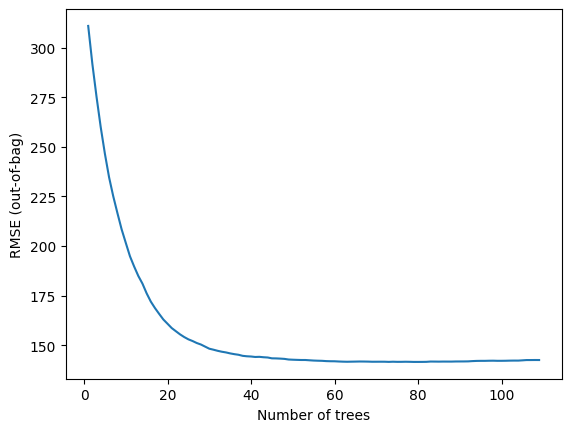

In [ ]:
import matplotlib.pyplot as plt
logs = gbf.make_inspector().training_logs()
print(logs)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

We can also see some general stats on the OOB dataset:

In [ ]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=11154, accuracy=None, loss=None, rmse=153.80867620697995, ndcg=None, aucs=None, auuc=None, qini=None)

Now, let us run an evaluation using the validation dataset.

In [ ]:
evaluation = gbf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

3/3 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mse: 24168.4727
loss: 0.0000
mse: 24168.4727


## Variable importance

In [ ]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("bedroom" (1; #3), 135.0),
 ("title" (1; #9), 90.0),
 ("bedroom_per_bathroom" (1; #4), 39.0),
 ("loc" (4; #6), 23.0),
 ("GeoPoliticalZone" (1; #0), 10.0),
 ("house_vs_room" (1; #5), 3.0)]

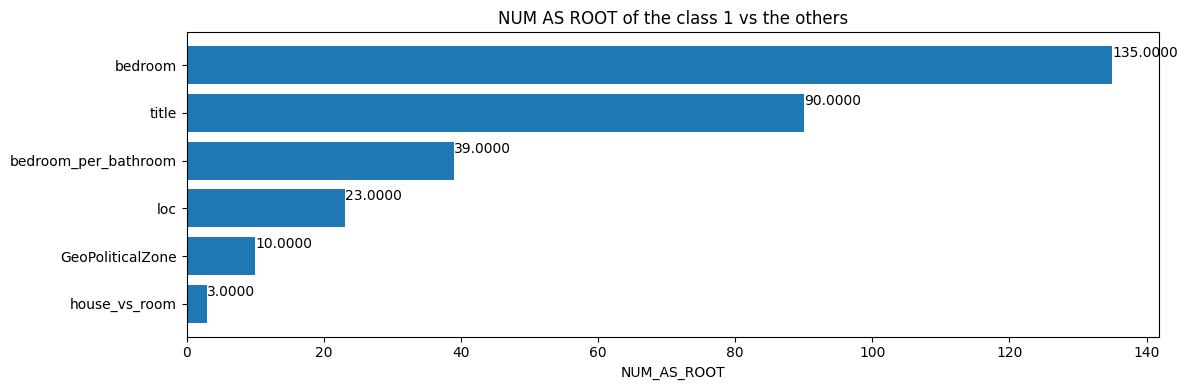

In [ ]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

## Deductions

With Random Forest Model, we had a Root Mean Square Error of

With Gradient Boosted Tree Model, we had a Root Mean Square Error of

For the Submission, we will use the Gradient Boosted Tree Model

# Submission
Finally predict on the competition test data using the model.

For the final submission, Gradient Bootsted tree was used.


We'll be using the same feature engineering transformations we did on the training data on the test data

In [ ]:
test_file_path = "/content/drive/MyDrive/dsn2023/Housing_dataset_test.csv"
test_data = pd.read_csv(test_file_path)

test_data['bedroom_per_bathroom'] = round(test_data.bedroom+1/test_data.bathroom, 0)
test_data['parking_space_per_bedroom'] = round(test_data.parking_space+1/test_data.bedroom, 0)


map = {
    'Benue':'North-Central', 'Kogi':'North-Central', 'Kwara':'North-Central', 'Nasarawa':'North-Central', 'Niger':'North-Central', 'Plateau':'North-Central', 'Abuja':'North-Central',
    'Adamawa':'North-East', 'Bauchi':'North-East', 'Borno':'North-East', 'Gombe':'North-East', 'Taraba':'North-East', 'Yobe':'North-East',
    'Jigawa':'North-West', 'Kaduna':'North-West', 'Kano':'North-West', 'Katsina':'North-West', 'Kebbi':'North-West', 'Sokoto':'North-West', 'Zamfara':'North-West',
    'Abia':'South-East', 'Anambra':'South-East', 'Ebonyi':'South-East', 'Enugu':'South-East', 'Imo':'South-East',
    'Akwa Ibom':'South-South', 'Bayelsa':'South-South', 'Cross River':'South-South', 'Delta':'South-South', 'Edo':'South-South', 'Rivers':'South-South',
    'Ekiti':'South-West', 'Lagos':'South-West', 'Ogun':'South-West', 'Ondo':'South-West', 'Osun':'South-West', 'Oyo':'South-West'
}
test_data['GeoPoliticalZone'] = test_data['loc'].copy()
test_data['GeoPoliticalZone'] = test_data['GeoPoliticalZone'].map(map)


test_data['house_vs_room'] = test_data.title.copy()


map = {'Semi-detached duplex':'house', 'Apartment':'room',
        'Detached duplex':'house', 'Terrace duplex':'house',
        'Mansion':'house', 'Bungalow':'house', 'Penthouse':'house',
        'Townhouse':'house', 'Flat':'room', 'Cottage':'house'}

test_data['house_vs_room'] = test_data['house_vs_room'].map(map)
map = {'house':1, 'room':2}
test_data['house_vs_room'] = test_data['house_vs_room'].map(map)

house_type_ranks = {
    'North-West': 3,
    'South-West': 2,
    'South-East': 6,
    'North-Central': 4,
    'North-East': 5,
    'South-South': 1
}

# Map the house types to numerical values based on size ranking
test_data['GeoPoliticalZone'] = test_data['GeoPoliticalZone'].map(house_type_ranks)

house_type_ranks = {
    'Cottage': 1,
    'Bungalow': 2,
    'Townhouse': 3,
    'Terrace duplex': 4,
    'Detached duplex': 5,
    'Semi-detached duplex': 6,
    'Flat': 7,
    'Penthouse': 8,
    'Apartment': 9,
    'Mansion': 10
}

# Map the house types to numerical values based on size ranking
test_data['title'] = test_data['title'].map(house_type_ranks)


## Make Predictions

In [ ]:
ids = test_data.pop('ID')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)
# Predict with gbf model
preds = gbf.predict(test_ds)
output = pd.DataFrame({'ID': ids,
                       'price': np.square(preds.squeeze())}) # Converting the square root back to square

output.head()

6/6 [==============================] - 0s 17ms/step


,ID,price
0,845,2244897.25
1,1924,1027318.00
2,10718,1135930.00
3,12076,9186918.00
4,12254,2041717.25


In [ ]:
output.to_csv('submission-gbf.csv', index=False)
output.head()

,ID,price
0,845,2244897.25
1,1924,1027318.00
2,10718,1135930.00
3,12076,9186918.00
4,12254,2041717.25


In [ ]:
output.shape

(6000, 2)